# Introduction

The dataset I used was prepared (Please see Assignment 2 - Data Quality Preperation) in a seperate notebook where I talked about the changes to the unclean dataset and made some changes to it so that it would be fit for this assignment. I will be creating three models to predict the outcome of the target feature **death_yn**. 

The notebook will be broken into 4 parts:
1. Reviewing the dataset from the first assignment and see which features to use to build the models.
2. Create a Linear Regression model and analyze.
3. Create a Logistical Regression model and analyze.
4. Create a Random Forest and analyze.
5. Try to optimize each model made.

In [1]:
# Importing the modules that will be used in this assignment.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Data Understanding and Preparation

Below is the data quality plan that was implemented on the uncleaned dataset that was provided for this assignment. I have decided to clean a new dataset that was provided in the zip file. As said before, please refer to the seperate notebook if you wish to see how it was cleaned and the changes that were made into more detail. I had created a new one and so I am not using the previous cleaned dataset from homework 1.

<img style="float: left;" src="dataqualityplan.PNG">

## 1.1 Review, prepare and splitting the dataset into two datasets: 70% for training and 30% for testing

In [2]:
# Read the csv file and put as df
df = pd.read_csv('Cleaned_Dataset', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
df.head(10)

,cdc_case_earliest_dt,onset_missing_ind,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-10-21,1,Laboratory-confirmed case,Female,30 - 39 Years,Hispanic/Latino,Unknown,Unknown,No,Yes
1,2020-03-31,1,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,No,No,No,No
2,2021-01-07,0,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,Unknown,Unknown,No,Unknown
3,2020-11-24,1,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,No,No,No,No
4,2021-01-05,0,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,Unknown,Unknown,No,Unknown
5,2021-01-12,0,Laboratory-confirmed case,Female,10 - 19 Years,"Multiple/Other, Non-Hispanic",Unknown,Unknown,No,Unknown
6,2020-11-28,1,Laboratory-confirmed case,Male,50 - 59 Years,"White, Non-Hispanic",No,Unknown,No,Unknown
7,2020-10-28,1,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",Unknown,Unknown,No,No
8,2021-01-14,1,Laboratory-confirmed case,Male,40 - 49 Years,"White, Non-Hispanic",Unknown,Unknown,No,Unknown
9,2020-09-27,1,Laboratory-confirmed case,Female,30 - 39 Years,Hispanic/Latino,No,Unknown,No,Unknown


In [3]:
# Exploring the dataset where we check the shape, the datatypes and check for any missing values
df.shape

(9976, 10)

In [4]:
df.dtypes

cdc_case_earliest_dt       object
onset_missing_ind           int64
current_status             object
sex                        object
age_group                  object
race_ethnicity_combined    object
hosp_yn                    object
icu_yn                     object
death_yn                   object
medcond_yn                 object
dtype: object

In [5]:
df.isna().sum()

cdc_case_earliest_dt       0
onset_missing_ind          0
current_status             0
sex                        0
age_group                  0
race_ethnicity_combined    0
hosp_yn                    0
icu_yn                     0
death_yn                   0
medcond_yn                 0
dtype: int64

In [6]:
for column in df:
    print(column, ":\n", df[column].unique())

cdc_case_earliest_dt :
 ['2020-10-21' '2020-03-31' '2021-01-07' '2020-11-24' '2021-01-05'
 '2021-01-12' '2020-11-28' '2020-10-28' '2021-01-14' '2020-09-27'
 '2021-01-02' '2020-12-21' '2021-01-08' '2020-12-04' '2020-05-25'
 '2020-11-20' '2020-04-23' '2020-12-14' '2020-11-21' '2020-09-10'
 '2020-09-17' '2020-05-07' '2020-12-19' '2020-07-28' '2020-12-09'
 '2020-08-29' '2020-12-17' '2020-05-19' '2020-06-27' '2020-03-20'
 '2020-11-02' '2020-10-18' '2020-07-21' '2020-11-26' '2020-12-12'
 '2020-07-02' '2020-11-05' '2020-11-22' '2021-01-10' '2020-12-02'
 '2020-09-24' '2020-12-13' '2020-04-29' '2021-01-04' '2020-10-03'
 '2020-11-23' '2020-08-25' '2020-12-25' '2020-05-11' '2020-12-30'
 '2020-12-29' '2020-11-08' '2020-12-27' '2020-11-25' '2020-11-10'
 '2020-08-28' '2020-08-03' '2020-09-18' '2020-09-19' '2020-08-07'
 '2020-12-22' '2020-07-06' '2021-01-09' '2020-07-16' '2020-10-16'
 '2020-07-27' '2020-11-12' '2020-10-17' '2020-06-10' '2020-11-07'
 '2020-09-14' '2020-04-20' '2020-09-30' '2020-07-29'

**Review so far:**
<br>
We see that there are no missing values to investigate. I will convert the object types into category and datetime to which that applies. 
* cdc_case_earliest_ dt will be converted into datetime.
* onset_missing_ind is a missing indicator feature that tells us if the onset date was available or it was missing. This will be kept as int64.
* current_status, sex, age_group, race_ethnicity_combined, hosp_yn, icu_yn, death_yn, medcond_yn will be converted to category type.
* Convert categorical features so that they have dummy variables. Still set their data types as categorical.

In [7]:
# Converting cdc_case_earliest_dt to datetime feature
df['cdc_case_earliest_dt'] = pd.to_datetime(df['cdc_case_earliest_dt'])

In [8]:
# Create categorical features then convert them to category types
cat_features = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 
                'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']

for column in cat_features:
    df[column] = df[column].astype('category')
    
# Also convert onset_missing_ind as it was initially to indicate if the value is missing
# And so it can be treated as a categorical feature (true or false)
df['onset_missing_ind'] = df['onset_missing_ind'].astype('category')

In [9]:
df.dtypes

cdc_case_earliest_dt       datetime64[ns]
onset_missing_ind                category
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                         category
medcond_yn                       category
dtype: object

We will set the target feature as y
We will set X to be the remaining features in the dataframe so we drop death_yn from the dataframe.

In [10]:
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)

,cdc_case_earliest_dt,onset_missing_ind,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-10-21,1,Laboratory-confirmed case,Female,30 - 39 Years,Hispanic/Latino,Unknown,Unknown,No,Yes
1,2020-03-31,1,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,No,No,No,No
2,2021-01-07,0,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,Unknown,Unknown,No,Unknown
3,2020-11-24,1,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,No,No,No,No
4,2021-01-05,0,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,Unknown,Unknown,No,Unknown


In [11]:
# Splitting the dataset up
# Creating own target feature dataframe and removing target feature from the main dataframe
df_death_dummy = pd.get_dummies(df['death_yn'], prefix='death_yn')
y = pd.DataFrame(df_death_dummy)
X = df.drop(['death_yn'], 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  9976
training range (70%):	 rows 0 to 6983
test range (30%): 	 rows 6983 to 9976


In [13]:
X_train

,cdc_case_earliest_dt,onset_missing_ind,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,medcond_yn
1253,2020-12-31,1,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,No,Unknown,Unknown
4363,2020-12-07,0,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,No,Unknown,Unknown
1153,2020-11-10,1,Laboratory-confirmed case,Male,30 - 39 Years,"Multiple/Other, Non-Hispanic",No,Unknown,Unknown
6988,2020-06-30,0,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Unknown,Unknown
8302,2020-12-16,0,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...
2895,2020-11-17,0,Laboratory-confirmed case,Male,30 - 39 Years,"Black, Non-Hispanic",Unknown,Unknown,Unknown
7813,2020-10-08,1,Laboratory-confirmed case,Female,30 - 39 Years,"White, Non-Hispanic",No,Unknown,Yes
905,2020-11-01,1,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",Unknown,Unknown,Unknown
5192,2020-11-30,1,Laboratory-confirmed case,Female,80+ Years,"White, Non-Hispanic",No,Unknown,Yes


## 1.2 Carry out a series of plots to compare all features to help make decisions to keep for the model

### Plot datetime feature against the target feature

In [14]:
X_train.cdc_case_earliest_dt = pd.to_numeric(X_train.cdc_case_earliest_dt)
df_temp = pd.concat([X_train['cdc_case_earliest_dt'], y_train], axis=1)
correlation = df_temp[["cdc_case_earliest_dt", "death_yn_Yes", "death_yn_No"]].corr(method='pearson')
correlation

,cdc_case_earliest_dt,death_yn_Yes,death_yn_No
cdc_case_earliest_dt,1.000000,-0.109002,0.109002
death_yn_Yes,-0.109002,1.000000,-1.000000
death_yn_No,0.109002,-1.000000,1.000000


<AxesSubplot:xlabel='cdc_case_earliest_dt', ylabel='death_yn_Yes'>

<Figure size 432x288 with 0 Axes>

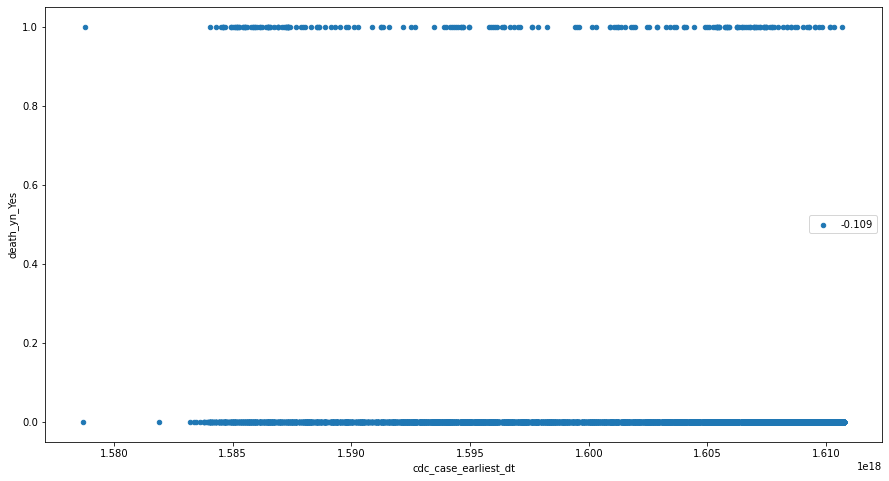

In [15]:
fig = plt.figure()
ax = fig.add_subplot
df_temp.plot(kind='scatter', x='cdc_case_earliest_dt', y='death_yn_Yes', label = "%.3f" % df_temp[['death_yn_Yes', 'cdc_case_earliest_dt']].corr().to_numpy()[0,1], figsize=(15, 8)) 

**Interpreting the result:**
<br>
* After observing the this graph, we see no clear, defined correlation between cdc_case_earlist_dt and the target feature.
* As the correlation is 0.1, we conclude that the datetime feature has a low correlation with the target feature.
* It means that the cdc_case_earliest_dt's relationship with death_yn_Yes is not strong.

### Plot interaction between categorical features and the target feature

In this section we will plot the interactions between each categorical feature against the target feature. Deciding which categorical feature that seem to be better at predicting the target feature will be discussed. I will choose a subset of categorical features based on the findings below. 

In [16]:
# Convert the target feature to categorical 
y_train = y_train.astype('category')

In [17]:
# Creating a temporary dataframe to plot by merging X_train and y_train
df_temp = pd.concat([X_train, y_train], axis=1)
df_temp.pop('cdc_case_earliest_dt')
df_temp.head(5)

,onset_missing_ind,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,medcond_yn,death_yn_No,death_yn_Yes
1253,1,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,No,Unknown,Unknown,1,0
4363,0,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,No,Unknown,Unknown,1,0
1153,1,Laboratory-confirmed case,Male,30 - 39 Years,"Multiple/Other, Non-Hispanic",No,Unknown,Unknown,1,0
6988,0,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Unknown,Unknown,1,0
8302,0,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,Unknown,Unknown,Unknown,1,0


In [18]:
categorical_columns_no_dummy = ['onset_missing_ind', 'current_status', 'sex', 'age_group', 'race_ethnicity_combined',
                               'hosp_yn', 'icu_yn', 'medcond_yn']

In [19]:
df_temp = pd.concat([X_train, y_train], axis=1)


 onset_missing_ind
Index 		 Count
1 	 3600
0 	 3383

 current_status
Index 		 Count
Laboratory-confirmed case 	 6522
Probable Case 	 461

 sex
Index 		 Count
Male 	 3262
Female 	 3677
Unknown 	 44

 age_group
Index 		 Count
30 - 39 Years 	 1180
50 - 59 Years 	 947
20 - 29 Years 	 1335
40 - 49 Years 	 1067
10 - 19 Years 	 759
70 - 79 Years 	 407
60 - 69 Years 	 709
0 - 9 Years 	 278
80+ Years 	 301

 race_ethnicity_combined
Index 		 Count
Unknown 	 2868
Multiple/Other, Non-Hispanic 	 372
White, Non-Hispanic 	 2248
Hispanic/Latino 	 703
Asian, Non-Hispanic 	 175
Black, Non-Hispanic 	 561
American Indian/Alaska Native, Non-Hispanic 	 44
Native Hawaiian/Other Pacific Islander, Non-Hispanic 	 12

 hosp_yn
Index 		 Count
No 	 3683
Unknown 	 2860
Yes 	 440

 icu_yn
Index 		 Count
Unknown 	 5982
No 	 746
Yes 	 255

 medcond_yn
Index 		 Count
Unknown 	 5703
No 	 644
Yes 	 636


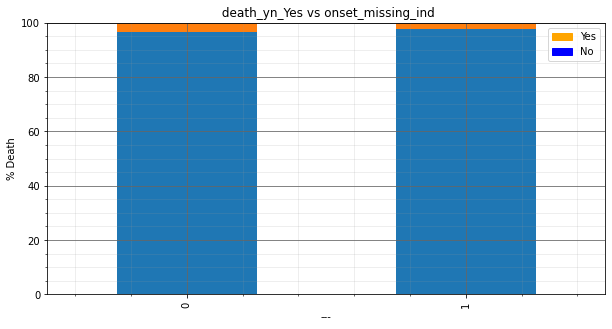

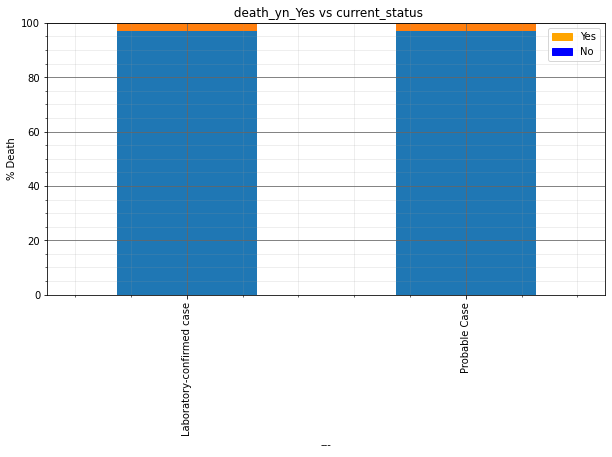

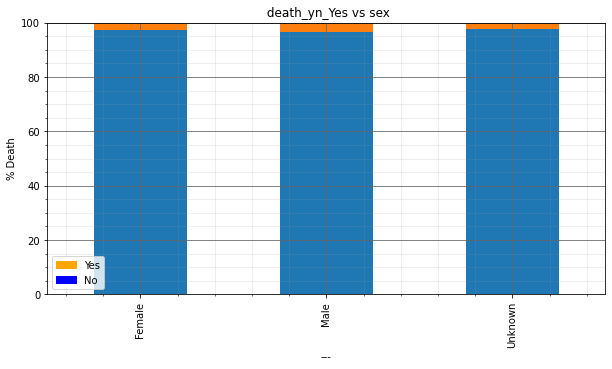

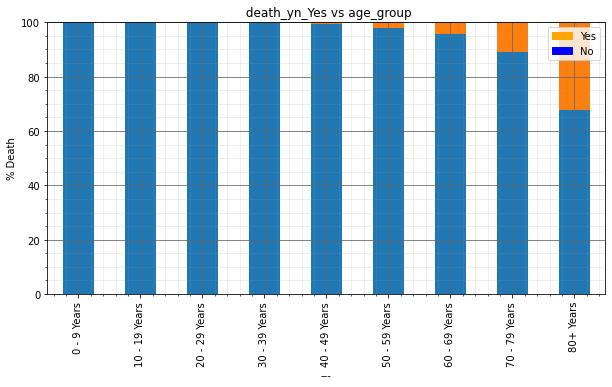

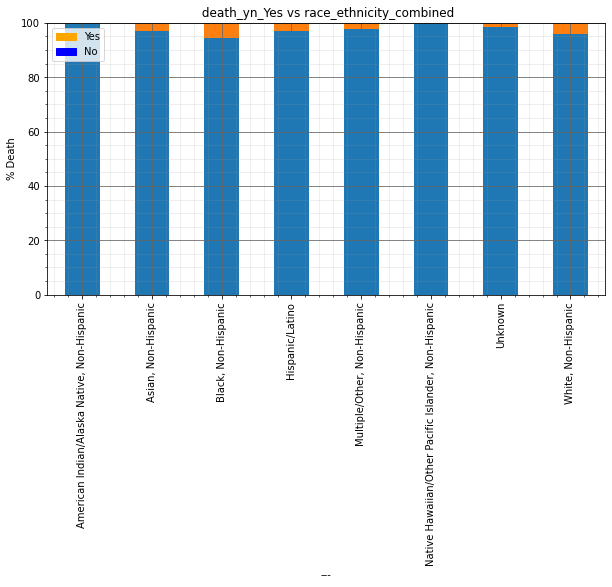

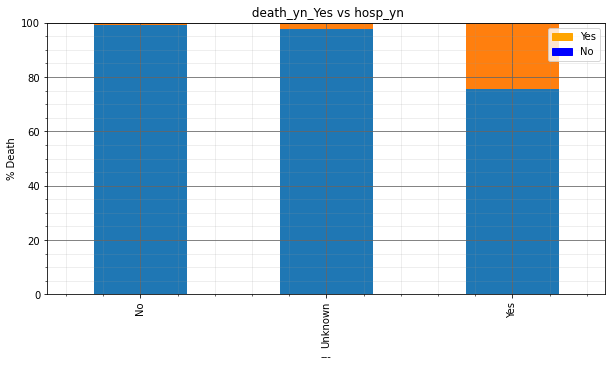

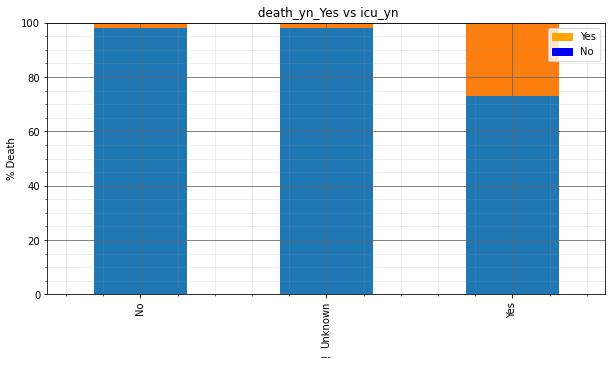

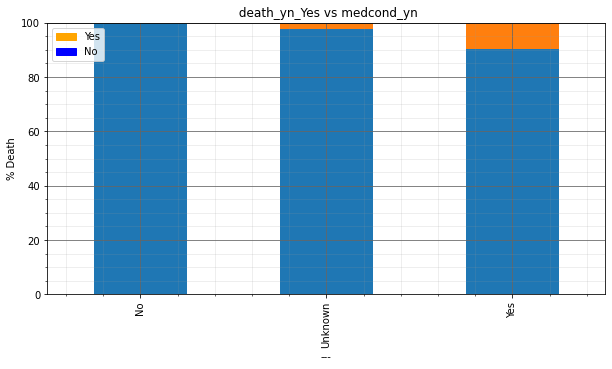

In [20]:
# We will now create a stacked bar plot to investigate the correlation between each categorical feature

for feature in categorical_columns_no_dummy:
    categ_feat = pd.unique(df_temp[feature].ravel())
    df_temp['percent'] = 0
    
    print("\n", feature)
    print("Index \t\t Count")
    
    for categorical_feature in categ_feat:
        count = df_temp[df_temp[feature] == categorical_feature].count()['death_yn_Yes']
        count_percentage = (1/count) * 100
        print(categorical_feature, "\t", count)
        
        index = df_temp[df_temp[feature] == categorical_feature].index.tolist()
        for ind in index:
            df_temp.loc[ind, 'percent'] = count_percentage
        
    grouped = df_temp[['percent', feature, 'death_yn_Yes']].groupby([feature, 'death_yn_Yes']).sum()
    plot = grouped.unstack().plot(kind='bar', stacked=True, title=f' death_yn_Yes vs {feature}', figsize=(10,5), grid=True)
    
    # Adding legends
    red = mpatches.Patch(color='orange', label='Yes')
    blue = mpatches.Patch(color='blue', label='No')
    plot.legend(handles=[red, blue], frameon = True)
    # Adding gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # Adding labels
    # add labels
    # add labels
    plot.set_xlabel("---")
    plot.set_ylabel("% Death")
    plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

#### Interperating the results:
##### _death_yn vs onset_missing_ind_
* From this plot, we see patients who had dates that showed they were experiencing symptoms has a slightly higher risk of death. 
* During data preperation, there was an indication that suggested missing data resulted in higher deaths. This may be useful and capturing this data may prove to be sufficient.

##### _death_yn vs current_status_
* After observing the plot, the % of deaths resulting to positive has no impact to the target feature. Even if te disparity of laboratory cases to probable cases the % is not big enough to say whether this feature would be useful for predicting the target feature.
* It is unlikely the binary outcome will capture this data sufficiently.

##### _death_yn vs sex_
* Observing this plot, we see unknown does not serve relevant results.
* Over the course of a year we see no signs of any big increase in positive deaths for any of the values for this feature (< 5%).
* Male and female values that have a higher % chance and are almost matching in this percentage. 
* However, it is unlikely the binary outcome will capture data sufficiently.

##### _death_yn vs age_group_
* From this observation we see that the % of death occurs as the age_group increases.
* Age group of 80+ years, accounting 3% of the dataset for the feature and so the % of death is easier to observe, which is expected.
* Even so, this shows promising correlations with the target feature as the death % for the age group with > 10%.
* It is likely the binary outcome will capture this data sufficiently.

##### _death_yn vs race_
* We see this plot and the % of risk of death falls to hawaiian/pacific islanders at about < 5% chance.
* Most race_ethnic groups have a likely chance of surviving for those who have probable and laboratory confirmed cases. 

##### _death_yn vs hosp_yn_
* From this observation, the % of yes for a person that is hospitalized has slightly less survivability rate.
* Conditions may have probably worsened or that the duration of their stay has made their conditions worse.
* 'Yes' accounts for 3.9% of patients but it is concerning to see just over 15% of hospitalized patients are more likely to die.
* It is likely the outcome will capture this data sufficiently.

##### _death_yn vs icu_yn_
* Observing this plot, we can see that patients were admitted to the ICU has a higher chance of death.
* The likelihood of patients who were not admitted to the ICU has less risk and more survivability rate.
* Unknown values similar to patients who were not admitted had lower risk of dying.
* It is likely the binary outcome will capture this data sufficiently.

##### _death_yn vs medcond_yn_
* Similarly to icu_yn, though not as gravely, we see a pattern in the likelihood of a patient having an existing medical condition the higher the risk of their chances of death.

**Features: age_group, hosp_yn, icu_yn and medcond_yn show promising correlations and so, they will be kept.**

**Summary:**
<br>
From continuous features: we see that **cdc_case_earliest_dt** showed low correlation with the target feature and so it will be dropped
<br><br>
From categorical features: we saw a lot of promising features that shows promising correlations to the target feature and some that did not. The following features will be kept: **age_group, hosp_yn, icu_yn and medcond_yn.** The following features will be dropped as they have low correlations: **current_status, race_ethnicity_combined, sex**

**Setting up dummy features**

In [21]:
# Create a copy of the dataframe
df_copy = df.copy()
df_copy = df_copy.drop(['cdc_case_earliest_dt', 'current_status', 'sex'], 1)

In [22]:
df_copy = pd.get_dummies(df_copy, drop_first=True)
df_copy.dtypes

onset_missing_ind_1                                                             uint8
age_group_10 - 19 Years                                                         uint8
age_group_20 - 29 Years                                                         uint8
age_group_30 - 39 Years                                                         uint8
age_group_40 - 49 Years                                                         uint8
age_group_50 - 59 Years                                                         uint8
age_group_60 - 69 Years                                                         uint8
age_group_70 - 79 Years                                                         uint8
age_group_80+ Years                                                             uint8
race_ethnicity_combined_Asian, Non-Hispanic                                     uint8
race_ethnicity_combined_Black, Non-Hispanic                                     uint8
race_ethnicity_combined_Hispanic/Latino               

In [23]:
# I will drop the following dummy features: hosp_yn_Unknown, icu_yn_Unknown, medcond_yn_Unknown as if Yes and No are 0 it implies that Unknown would be 1.
# df_copy = df_copy.drop(['hosp_yn_Unknown', 'icu_yn_Unknown', 'medcond_yn_Unknown'], 1)
# This functions attempts to find the reference variables and removing them from the data frame
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculatevif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
#             print('dropping ' + X.iloc[:, variables].columns[maxloc] + ' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

#     print('Remaining variables:')
#     print(X.columns[variables])
    return X.iloc[:, variables]

df_copy = calculatevif(df_copy)
df_copy.head(10)

,onset_missing_ind_1,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,age_group_70 - 79 Years,age_group_80+ Years,"race_ethnicity_combined_Asian, Non-Hispanic",...,"race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_ethnicity_combined_Unknown,"race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Unknown,hosp_yn_Yes,icu_yn_Unknown,icu_yn_Yes,death_yn_Yes,medcond_yn_Unknown,medcond_yn_Yes
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
3,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
6,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
7,1,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
8,1,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,1,0,0,1,0
9,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Setting the continuous columns
In this case there are no continuous columns

### Setting the categorical columns


In [24]:
# Setting the categorical columns and we remove death_yn from the list
categorical_columns = df_copy.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns 

['onset_missing_ind_1',
 'age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'age_group_80+ Years',
 'race_ethnicity_combined_Asian, Non-Hispanic',
 'race_ethnicity_combined_Black, Non-Hispanic',
 'race_ethnicity_combined_Hispanic/Latino',
 'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
 'race_ethnicity_combined_Unknown',
 'race_ethnicity_combined_White, Non-Hispanic',
 'hosp_yn_Unknown',
 'hosp_yn_Yes',
 'icu_yn_Unknown',
 'icu_yn_Yes',
 'death_yn_Yes',
 'medcond_yn_Unknown',
 'medcond_yn_Yes']

### Setting the low correlation features

In [25]:
low_correlation_features = ['cdc_case_earliest_dt', 'current_status', 'sex']

### Setting the high correlation features

In [26]:
high_correlation_features = ['age_group', 'hosp_yn', 'medcond_yn', 'icu_yn', 'race_ethnicity_combined']

In [27]:
# Adding the two features together we get:
features = categorical_columns
features

['onset_missing_ind_1',
 'age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'age_group_80+ Years',
 'race_ethnicity_combined_Asian, Non-Hispanic',
 'race_ethnicity_combined_Black, Non-Hispanic',
 'race_ethnicity_combined_Hispanic/Latino',
 'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
 'race_ethnicity_combined_Unknown',
 'race_ethnicity_combined_White, Non-Hispanic',
 'hosp_yn_Unknown',
 'hosp_yn_Yes',
 'icu_yn_Unknown',
 'icu_yn_Yes',
 'death_yn_Yes',
 'medcond_yn_Unknown',
 'medcond_yn_Yes']

In [28]:
features.pop(19)

'icu_yn_Yes'

In [29]:
features

['onset_missing_ind_1',
 'age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'age_group_80+ Years',
 'race_ethnicity_combined_Asian, Non-Hispanic',
 'race_ethnicity_combined_Black, Non-Hispanic',
 'race_ethnicity_combined_Hispanic/Latino',
 'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
 'race_ethnicity_combined_Unknown',
 'race_ethnicity_combined_White, Non-Hispanic',
 'hosp_yn_Unknown',
 'hosp_yn_Yes',
 'icu_yn_Unknown',
 'death_yn_Yes',
 'medcond_yn_Unknown',
 'medcond_yn_Yes']

In [30]:
df_copy.dtypes

onset_missing_ind_1                                                             uint8
age_group_10 - 19 Years                                                         uint8
age_group_20 - 29 Years                                                         uint8
age_group_30 - 39 Years                                                         uint8
age_group_40 - 49 Years                                                         uint8
age_group_50 - 59 Years                                                         uint8
age_group_60 - 69 Years                                                         uint8
age_group_70 - 79 Years                                                         uint8
age_group_80+ Years                                                             uint8
race_ethnicity_combined_Asian, Non-Hispanic                                     uint8
race_ethnicity_combined_Black, Non-Hispanic                                     uint8
race_ethnicity_combined_Hispanic/Latino               

In [31]:
datas = {'death_yn_Yes': df_copy['death_yn_Yes']}
y = pd.DataFrame(data=datas)
X = df_copy.drop(['death_yn_Yes'],1)

In [32]:
# Splitting the dataset into 2 datasets: 
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("The Original range of the dataset: ",df.shape[0])
print("The Training range taken from dataset: (70%): rows 0 to", round(X_train.shape[0]))
print("The Test range taken from dataset: (30%): rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The Original range of the dataset:  9976
The Training range taken from dataset: (70%): rows 0 to 6983
The Test range taken from dataset: (30%): rows 6983 to 9976


In [33]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
       onset_missing_ind_1  age_group_10 - 19 Years  age_group_20 - 29 Years  \
1253                    1                        0                        0   
4363                    0                        0                        0   
1153                    1                        0                        0   
6988                    0                        0                        0   
8302                    0                        0                        1   

      age_group_30 - 39 Years  age_group_40 - 49 Years  \
1253                        1                        0   
4363                        1                        0   
1153                        1                        0   
6988                        0                        0   
8302                        0                        0   

      age_group_50 - 59 Years  age_group_60 - 69 Years  \
1253                        0                        0   
4363                        0  

In [34]:
# I will reset the indexes of the training and test splits so we can see the X_train printout
# We will see that they are no longer in order and the next markdown cell I will reset the indexes.
X_train.head(5)

,onset_missing_ind_1,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,age_group_70 - 79 Years,age_group_80+ Years,"race_ethnicity_combined_Asian, Non-Hispanic",...,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_ethnicity_combined_Unknown,"race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Unknown,hosp_yn_Yes,icu_yn_Unknown,icu_yn_Yes,medcond_yn_Unknown,medcond_yn_Yes
1253,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4363,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1153,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
6988,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
8302,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0


In [35]:
# Using .reset_index 
# We see that they are in order again. 
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(10)

,onset_missing_ind_1,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,age_group_70 - 79 Years,age_group_80+ Years,"race_ethnicity_combined_Asian, Non-Hispanic",...,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_ethnicity_combined_Unknown,"race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Unknown,hosp_yn_Yes,icu_yn_Unknown,icu_yn_Yes,medcond_yn_Unknown,medcond_yn_Yes
0,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
5,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
9,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


# 2. Linear Regression

- (2.1) On the training set, train a linear regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. 
- (2.2) Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).    
- (2.3) Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
- (2.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings.

## 2.1 Training a linear regression model to predict the target feature, using only the descriptive features selected in exercise 1.

In [36]:
multiple_linear = LinearRegression().fit(X_train, y_train)

## 2.2 Printing out the coefficients learned by the model and discussing the role in the model.

In [37]:
print("\nThe features are: \n", X_train.columns)
print("\nThe coefficients are: \n", multiple_linear.coef_)
print("\n The intercept is: \n", multiple_linear.intercept_)
print("\nFeatures and coefficients: \n", list(zip(X_train.columns, multiple_linear.coef_[0])))


The features are: 
 Index(['onset_missing_ind_1', 'age_group_10 - 19 Years',
       'age_group_20 - 29 Years', 'age_group_30 - 39 Years',
       'age_group_40 - 49 Years', 'age_group_50 - 59 Years',
       'age_group_60 - 69 Years', 'age_group_70 - 79 Years',
       'age_group_80+ Years', 'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_Unknown',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Unknown',
       'hosp_yn_Yes', 'icu_yn_Unknown', 'icu_yn_Yes', 'medcond_yn_Unknown',
       'medcond_yn_Yes'],
      dtype='object')

The coefficients are: 
 [[-0.01287134  0.00342992  0.00314648  0.00335051  0.00083453  0.00848805
   0.02308906  0.06929292  0.26820515  0.01067522  0.02716148  0.02112

##### Discussion about the coefficients and their role in the linear regression model
* The tool used predicts based on the linear relationships between the target feature and of the independent variables.
    - It finds the line of best fit the describes the relationship between the target and predictors 
    - This line is calculated by minimising the overall error
* The output of the lienar regression formula is a continuous value that can either be less than 0 or higher than 1. From the results, we see that the caluclated intercept is -0.03
* What this tells is that it represents w_0 and any other features that would result in -0.03 will have that answer meaning it is where it intercept the y-axis.
* We can make direct comparisons as the data has already been normalized after we hard coded the values of each feature when making the dummy variables. 
* We see a lot of low co-efficients that is less than 10%. The lowest one being age_group_40-49 years at 0.00083453 meaning the relationship between the target feature and this feature is the weakest. And that the dependency of the target feature on this feature is very low. 
* In comparison, we see the highest co-efficient value is age_group 80+ years at 0.26820515. This indicates a better relationship with the target feature. What this tells us how much the target feature is expected to increase in an average each time the age_group 80+ years increases by 1.
* To finish off, we see most features have low co-efficients which tells us that the linear relationships between the target feature and independent variables are small.

## 2.3 Printing the predicted target feature and threshold the predicted target value at 0.5. Printing the predicted class for a few examples. Printing classification evaluation measures computed on the full training set. 

In this section I will print out around 100 predicted target feature value given by the linear regression model at 0.5.


In [38]:
# Calculating the prediction and threshold value. 
multiple_linear_predictions_train_data = (multiple_linear.predict(X_train) >= 0.5) * 1.0

In [39]:
print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linear_predictions_train_data, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   death_yn_Yes  Predicted
0             0        0.0
1             0        0.0
2             0        0.0
3             0        0.0
4             0        0.0
5             0        0.0
6             0        0.0
7             0        0.0
8             0        0.0
9             0        0.0


In [40]:
# Printing the a few classification evaluation measures computed on the full training set.
# The following will be printed: accuracy, confusion matrix, precision, recall, f1).
# Some more evaluation metrics.
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linear_predictions_train_data))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linear_predictions_train_data))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linear_predictions_train_data))

Accuracy:  0.9712158098238579
Confusion matrix: 
 [[6777    0]
 [ 201    5]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.99      6777
           1       1.00      0.02      0.05       206

    accuracy                           0.97      6983
   macro avg       0.99      0.51      0.52      6983
weighted avg       0.97      0.97      0.96      6983



##### Commenting on the results:
* Accuracy:
    * In terms of accuracy, we have an accuracy of 97.12%. This tells us how often the model was correct.
* Confusion Matrix:
    * [Top Left] True Negative -> The number that is predicted 0 that was actually 0.
    * [Top Right] False Positive -> The number that is predicted 1 that is actually 0.
    * [Bottom Left] False Negative -> The number is predicted 0 that is actually 1.
    * [Bottom Right] True Positive -> The number that is predicted that is actually 1.
* Precision:
    * Precision Positive is 1.00 (100%)
    * Prediction Negative is 0.97 (97%)
* Recall:
    * Recall is the % of the positive values that was predicted.
    * Recall negative is 1.00 (100%)
    * Recall positive is 0.02 (2%)
* F1 Score:
    * It is a weighted average of the precision and recall.
    * F1 score negative is 0.99. (99%)
    * F1 score positive is 0.05. (5%)
 
 ##### Summary:
 * The accuracy gives us the indication how often our model was correct which is around 97%. Though this is a good indication, our confusion matrix demonstrates that it is not symmetric.
 * The precision gives an indication of correctly positive predicted observations to the total of predicted positive observations. It is mostly a good score as for predicting death_yn_Yes we get a score of 1.00. However for predicting death_yn_No we have some false negatives and have a score of 0.97.
 * One thing to note that is worth mentioning is the low score for recall positive as it is at 0.02 and the threshold was 0.5.
 * For our F1 score, it gave us a better picture as it takes false negatives and false positives into account. We see that f1 score positive is 0.05 which means the majority of true positives were predicted as false negatives. 


## 2. 4 Evaluating the model using classification evaluation measures on the hold-out (30% examples) test set.

In [41]:
# I will calculate the prediction and threshold the value for 0.5
multiple_linear_predictions_testing = (multiple_linear.predict(X_test) >= 0.5) * 1.0

print("\nPredictions that has multiple linear regression: \n")
actual_vs_predicted_multiple_linear_reg = pd.concat([y_test, pd.DataFrame(multiple_linear_predictions_testing, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiple_linear_reg)


Predictions that has multiple linear regression: 

      death_yn_Yes  Predicted
0                0        0.0
1                0        0.0
2                0        0.0
3                0        0.0
4                0        0.0
...            ...        ...
2988             1        0.0
2989             0        0.0
2990             0        0.0
2991             0        0.0
2992             0        0.0

[2993 rows x 2 columns]


In [42]:
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linear_predictions_testing))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linear_predictions_testing))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linear_predictions_testing))
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linear_predictions_train_data))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linear_predictions_train_data))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linear_predictions_train_data))

Accuracy:  0.9692616104243235
Confusion matrix: 
 [[2900    2]
 [  90    1]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2902
           1       0.33      0.01      0.02        91

    accuracy                           0.97      2993
   macro avg       0.65      0.51      0.50      2993
weighted avg       0.95      0.97      0.96      2993

Accuracy:  0.9712158098238579
Confusion matrix: 
 [[6777    0]
 [ 201    5]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.97      1.00      0.99      6777
           1       1.00      0.02      0.05       206

    accuracy                           0.97      6983
   macro avg       0.99      0.51      0.52      6983
weighted avg       0.97      0.97      0.96      6983



##### Interpretation of test results and comparing them with the training results
* Accuracy:
    * The accuracy of the test data is higher in the test data than the training data with the test data 98.83% compared to the training dtaa with 98.78%
* Precision:
    * The precision score for predicting a negative outcome stayed the same with it being 0.97.
    * The precision score for predicting a positive outcome is lower than the training data at 0.33.
* Recall:
    * The recall score for predicting a negative outcome stayed the same with it being 1.00.
    * The recall score for predicting a positive outcome is lower with it being 0.01.
* F1 Score:
    * The F1 score for predicting a negative outcome is lower by one point than the training data at 0.98.
    * The F1 score for predicting a positive outcome is lower by three points than the training data at 0.02.

 ##### Summary:
 * It it clear the differences for the testing data compared to the training data is slightly worse than the training data. We fall low to 1% for the recall score on the test data. Which indicates the correctly predicted positive observations to all of the observations was low as the true positive only calculated 1 correctly.
 * F1 score fell from 5% to 2%.
 * Precision score for predicting a positive outcomes fell from 100% to 33%.
 * From this data, it suggests that Linear Regression model does give accurate predictions as we could already see the co-efficients above that the linear relationships with the target feature is low. Which is expected.

##### Cross Validation
In this section I will perform cross validation. By performing this it means I will be the above but a couple more times. Each time this is repeated, I will shuffle the rows so that we can have a indication of the different results cross validation will produce. 

In [43]:
# Carrying out cross validation no the linear regression model. The default number of validation is 3. Random state will be updated at each iteration. 
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

Then, we will perform 10 fold cross validation which is to be used to simplify further analysis the dataset. I will simplify the dataset by lookinh at the accuracy, precision, recall and f1.

In [44]:
# Function to perform cross validation and store results in dataframe. This will look at the accuracy, precision, recall, f1.
def cross_val_LinReg_DF(X,y):
    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

In [45]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.969997
precision,0.658333
recall,0.013436
f1,0.026114


**Results**
<br>
These results are lower than the previous results. By taking the mean of 10 results, this is probably expected. Note that the accuracy stays consistent, at 96%. However, F1 score is very low. As this is a better performance measure to look as our dataset is not symmetrical, 2% is a low score.

# 3. Logistic Regression

- (3.1) On the training set, train a logistic regression model to predict the target feature, using the descriptive features selected in exercise (1) above.   
- (3.2) Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model).    
- (3.3) Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
- (3.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings.

## 3.1 Train a logistic regression model using only the descriptive features selected from question 1 above.

In [46]:
# Training a mode using all of the features
multiple_logistic = LogisticRegression().fit(X_train, y_train)
multiple_logistic

LogisticRegression()

## 3.2 Printing out the coefficients learned by the model and discussing the role in the model

In [47]:
# Using lip and zip to print them out side by side with the coefficients.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logistic.coef_[0])
print("\nIntercept is: \n", multiple_logistic.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logistic.coef_[0])))


Features are: 
 Index(['onset_missing_ind_1', 'age_group_10 - 19 Years',
       'age_group_20 - 29 Years', 'age_group_30 - 39 Years',
       'age_group_40 - 49 Years', 'age_group_50 - 59 Years',
       'age_group_60 - 69 Years', 'age_group_70 - 79 Years',
       'age_group_80+ Years', 'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_Unknown',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Unknown',
       'hosp_yn_Yes', 'icu_yn_Unknown', 'icu_yn_Yes', 'medcond_yn_Unknown',
       'medcond_yn_Yes'],
      dtype='object')

Coeficients are: 
 [-0.5222284  -1.46560064 -0.91664156 -0.69667612 -0.58040019  0.35132314
  1.00597231  1.68648511  3.17920727  0.07452281  0.57928111  0.5285904
 -0.1856

##### Discussion about the coefficients and their role in the logistic regression model
* The tool used predicts based on the logistic relationships between the target feature and of the independent variables.
* The output of a logistic function is a probability between 0 and 1.
* We see a direct relationship between the two.
* The different applications we do in logistic regression compared to linear regression is that after finding the line of best fit we pass this equation through a sigmoid function.
* It will output a value between 0 and 1 which is a probability. It is a probability that the model then applies a threshold to this. If it is <= 0.5 it will cast to 1 otherwise it will cast to 0.
* These are carried out in the regression function. 
* In this equation, we see that the intercept is -6.386. This means that if all other coefficients were zero then the value for 'x' would be -6.386.
* As for the co-efficients, it tells us how much the target feature is expected to decrease (0) or increase (1). 
* The coeffcients are closer to 1.0 compared to coeffcients in the Linear Regression model. Which indicates a stronger logistic relationship betwen the target feature and independent features.
* The weakest co-efficient value is different from the previous model, race_ethnicity_combined_Asian, Non-Hispanic. It has a co-efficient value of 0.0745. 
* A lot of co-efficient values are closer to 1.0 which means a lot of the features have a strong relationship with the target feature and has a higher probability of correctly predicting the outcome. 
* We would like to see the odds of each variable having a likeliness of them predicting a positive outcome i.e. predicting correctly. To do this, we calculate the exponential^coefficient of the variable. The result is the ratio of the odds for each variable in a certain feature.
* As such I will take the co-efficients and apply this equation so that we get a picture of the odd ratios to the target feature. 
* As we can see below, it tells us the odds of for e.g. a person who falls in the age_group 10-19 years has 0.2 times likely to end up successfully predicting the target feature positively while compared to hosp_yn_Yes who is 8.27 times more likely. We want to look at features that has the most likeliness of predicting the target feature positively. 
* In conclusion, the odd ratio tells us the corresponding to a one unit change in the variable.

In [48]:
coeffcients = multiple_logistic.coef_[0]
list_odds_ratio = []
for num in coeffcients:
    list_odds_ratio += [np.exp(num)]
    
print("\nFeatures and Odd Ratio: \n", list(zip(X_train.columns, list_odds_ratio)))


Features and Odd Ratio: 
 [('onset_missing_ind_1', 0.5931971949777559), ('age_group_10 - 19 Years', 0.23093923852378118), ('age_group_20 - 29 Years', 0.39985969454132614), ('age_group_30 - 39 Years', 0.4982386381512122), ('age_group_40 - 49 Years', 0.5596743439925129), ('age_group_50 - 59 Years', 1.4209464101616067), ('age_group_60 - 69 Years', 2.73456483530181), ('age_group_70 - 79 Years', 5.400465244347016), ('age_group_80+ Years', 24.02769845561508), ('race_ethnicity_combined_Asian, Non-Hispanic', 1.0773699146317655), ('race_ethnicity_combined_Black, Non-Hispanic', 1.7847549219231813), ('race_ethnicity_combined_Hispanic/Latino', 1.6965391734560447), ('race_ethnicity_combined_Multiple/Other, Non-Hispanic', 0.8305996257631021), ('race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic', 0.9204042133236675), ('race_ethnicity_combined_Unknown', 0.6117385306071372), ('race_ethnicity_combined_White, Non-Hispanic', 1.0414278711126044), ('hosp_yn_Unknown', 2.5222267613

## 3.3 Printing the predicted target feature value for the first few training examples. Printing classification evaluation measures and discussing findings so far.

In [49]:
# Here we will set the threshold value as >= 0.5. So if it's >= 0.5 it's true.
multiple_logistic_prediction_train = (multiple_logistic.predict(X_train)>= 0.5) * 1.0

# Printing out results
print("\nPrediction results with multiple linear regression: \n")
actual_vs_predicted_logistic_train = pd.concat([y_train ,pd.DataFrame(multiple_logistic_prediction_train,  columns=['Predicted'])], 
axis = 1)
print(actual_vs_predicted_logistic_train.head(10))


Prediction results with multiple linear regression: 

   death_yn_Yes  Predicted
0             0        0.0
1             0        0.0
2             0        0.0
3             0        0.0
4             0        0.0
5             0        0.0
6             0        0.0
7             0        0.0
8             0        0.0
9             0        0.0


In [50]:
# Printing performance measures 
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logistic_prediction_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logistic_prediction_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logistic_prediction_train))

Accuracy:  0.970929399971359
Confusion matrix: 
 [[6737   40]
 [ 163   43]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      6777
           1       0.52      0.21      0.30       206

    accuracy                           0.97      6983
   macro avg       0.75      0.60      0.64      6983
weighted avg       0.96      0.97      0.96      6983



Interpretation of the performative measures:
* Accuracy
    * We have an accuracy of 97%
* Precision 
    * Precision Positive is 0.55
    * Precision Negative is 0.98
* Recall 
    * Recall Positive is 0.24
    * Recall Negative is 0.99
* F1 Score: a weighted average of Precision and recall
    * F1 Score Positive is 0.33
    * F1 Score Negative is 0.99


Summary:
* In comparison to the Linear Regression model, there is a positive increase in predicting the positive class better.
* The numbers for the performance variables are better.
* The accuracy is in line with the Linear Regression model at 97% also.
* The positive precision score is at 52% meaning 52% of the total predicted positive observations were correct.
* The positive recall score is also an improvement from the linear regression model, meaning that 21% of correctly positive predicted outcomes were correct out of all classes from the confusion matrix.
* The positive F1 score is also higher. 
* To summarize, the negative predicted scores are al > 90% which is expected as the target train set is skewed where the majority is negative.

## 3.4 Evaluating the mode using classification measure on the hold-out (30%) test set. Then comparing results with training results. Also compare these results with a cross-validated model. 

In [51]:
# I will now compare the actual target feature vs the predicted test data
multiple_logistic_prediction_test = (multiple_logistic.predict(X_test) >= 0.5) * 1.0

# Printing out the results
print("\nPredictions with multiple linear regression:")
actual_vs_predicted_logistic_test = pd.concat([y_test, pd.DataFrame(multiple_logistic_prediction_test, columns=['Predicted'])], axis=1)
actual_vs_predicted_logistic_test


Predictions with multiple linear regression:


,death_yn_Yes,Predicted
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
2988,1,0.0
2989,0,0.0
2990,0,0.0
2991,0,0.0


In [52]:
# Comparing performance measures between train data and test data
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logistic_prediction_test))
print("Confusion matrix: Test Data\n", metrics.confusion_matrix(y_test, multiple_logistic_prediction_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logistic_prediction_test))
print()
print("Accuracy: ", metrics.accuracy_score(y_train,  multiple_logistic_prediction_train))
print("Confusion matrix: Training Data\n", metrics.confusion_matrix(y_train, multiple_logistic_prediction_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logistic_prediction_train))

Accuracy:  0.9736050785165385
Confusion matrix: Test Data
 [[2892   10]
 [  69   22]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      2902
           1       0.69      0.24      0.36        91

    accuracy                           0.97      2993
   macro avg       0.83      0.62      0.67      2993
weighted avg       0.97      0.97      0.97      2993


Accuracy:  0.970929399971359
Confusion matrix: Training Data
 [[6737   40]
 [ 163   43]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      6777
           1       0.52      0.21      0.30       206

    accuracy                           0.97      6983
   macro avg       0.75      0.60      0.64      6983
weighted avg       0.96      0.97      0.96      6983



Interpretation of the performative measures:
* Accuracy
    * We have an accuracy of 97%
* Precision 
    * Precision Positive is 0.69 (69%)
    * Precision Negative is 0.98 (98%)
* Recall 
    * Recall Positive is 0.24 (24%)
    * Recall Negative is 1.00 (100%)
* F1 Score: a weighted average of Precision and recall
    * F1 Score Positive is 0.35 (35%)
    * F1 Score Negative is 0.99 (99%)


Summary:
* The accuracy for testing data has dropped however very very slightly. This is a good indication that a logistic regression model works better.
* We see better results for the training data which indicates that the model is generalizing.
* The precision score has increased from 52% to 69%. The recall score increased from 21% -> 24%.
* The F1 score increased from 30% -> 35%.
* This shows that the logistic regression model is a better fit for our target feature as the test data shows better results for having more true positives from the confusion matrix.
* This would be expected as the logistic regression model deals with classifiers.

In [53]:
def cross_validation_logistic(X,y):
    logistic_results = {}
    # These are the test metrics that will be tested against.
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        logistic_results[metric] = result.mean()
        
    # create dataframe with results
    Logistic_Dataframe = pd.DataFrame.from_dict(logistic_results, orient='index', columns=['Logistic_Regression'])
    
    return Logistic_Dataframe

In [54]:
logistic_df = cross_validation_logistic(X,y)
print(f"Mean results from 10 fold cross validation are:")
logistic_df 

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.971131
precision,0.539332
recall,0.222414
f1,0.312748


These results are better than the previous results. The accuracy score has stayed the same more or less which is expected, Precision score has gone down from 55 -> 53, Recall has signigicantly improved that tells us it has a higher probability of correctly predicting positive observations over true positives plus false negatives. and the F1 score also had improvements from 0.02 -> 0.31. In conclusion this gives a better indication that Logistic Regression model is better than Linear Regression model for our target feature. 

# 4. Random Forest


* (4.1) On the training set, train a random forest model to predict the target feature, using the descriptive features selected in exercise (1) above.   
* (4.2) Can you interpret the random forest model? Discuss any knowledge you can gain in regard of the working of this model.   
* (4.3) Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
* (4.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and to the out-of-sample error and discuss your findings.

## 4.1 Training a random forest model using descriptive features from question 1 above.

In [55]:
# Training a random forest with 100 Trees
rfm = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)
rfm.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

## 4.2 Interpreting the random forest model. 

In this section, I will try get a better understanding of the random forest model by firstly going through the decision tree. 
<br>
**!For my own guidance!**
* The decision is tree is made up of if-else rules based on splitting data based on the specific features. 
* The decision on which feature will always split on the feature that gives the highest information gain.
* The feature with the highest information gain will sit at the root of each decision tree.
* Each decision tree will be a single prediction.
* Random Forest
    * The random forest is made up a number of decision trees.
    * The output of the random forest is base on the majority output of all decision trees combined.
    * This gives reliable results but can be hard to interpret.
    * The random forest will keep track of the importance of features in terms of information gain, which we will see.

In [56]:
# I will train 2 decision trees with the same test data
# One with max_depth of 4 and max_depth of 10.
# Note that max depth determines how deep a decision tree can go before it must 
# give an answer.
dtc_4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc_10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc_4.fit(X_train, y_train)
dtc_10.fit(X_train, y_train)
print("Max depth 4: \n",dtc_4)
print("Max depth 10: \n",dtc_10)

Max depth 4: 
 DecisionTreeClassifier(max_depth=4, random_state=1)
Max depth 10: 
 DecisionTreeClassifier(max_depth=10, random_state=1)


In [57]:
# Using Graphviz png I will crete a graph of each tree and save it as an image.
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc_4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc_10, out_file=f2, feature_names=X_train.columns)

#### max-depth = 4 - Random Forest Tree Model

<img style="float: left;" src="DecisionTree4.png">

#### max-depth = 10 -  Random Forest Tree Model

<img style="float: left;" src="DecisionTree10.png">

#### Interpretation of the Random Forest Tree Model:
##### max-depth: 4-model:
* We see the root node for this model is age_group 80+ years. This means that strongest feature in relation to the target feature.
* Increasing the trees would give us an increase of predicting precision of the outcome.
* age_grup 80+ years has a sample of 6983 meaning that there are 6983 observations in this node. 
* At the end of each decision nodes (the leaf nodes), we see look at the gini values to see the purity of leaf node. Gini impurities would tell the probability of incorrectly labelling if it was randomly labelled according to the distribution of labels.
* In this mode, we see the best branch and decision node (sub tree) would be hosp_yn_Yes -> age_group_70-79 years -> age_group 60-69 years as it gives the best feature split and gives the best information gain. 
* Leaf nodes that have a gini value of 0.0 give an indication of its purity and how useful the feature is in predicting the correct positive outcome of the target feature. And the branch I have mentioned above gives a pure gini value 0.0 that means indicates an accurate positive outcome.
* We see that the tree continues to split at the next best feature each time until the stopping criteria of max_depth = 4 is met.
##### max-depth: 10-model:
* In this section, I will attempt to analyze one branch from hosp_yn_Yes (True). As we travel down the branch, we reach age_group_70-79 years -> age_group_60-69 years -> hosp_yn_Unknown -> age_group_40-49 years. This decision tree tells us that the next best considered features that are branched off have closed.
* The gini values has measures that tell us that these features, depending on the node they branched from, represents the best feature split of this model. 
* We see that this path is resolved from this one split alone and all samples are in the positive class. 
* Again, we see that age_group_80+ years is still the root node. This gives us information that this feature is the strongest predictor of the outcome. 
* There are more impure gini scorees, that give a higher gini score that implies a positive outcome will not be as accurate. We see this if we follow when age_group_80+ years branch into False. 

In [58]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance': rfm.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
8,age_group_80+ Years,0.206194
17,hosp_yn_Yes,0.134932
0,onset_missing_ind_1,0.098857
19,icu_yn_Yes,0.080176
21,medcond_yn_Yes,0.051373
18,icu_yn_Unknown,0.048815
15,"race_ethnicity_combined_White, Non-Hispanic",0.046903
16,hosp_yn_Unknown,0.046900
20,medcond_yn_Unknown,0.040845
7,age_group_70 - 79 Years,0.038988


In [59]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f}'.format(rfm.score(X_train, y_train), rfm.oob_score_))

R^2 Training Score: 0.98 
OOB Score: 0.97


**Interpretation of the Feature Importance:**
<br>
* We see that age_group_80+ years is the most important feature that gives the best positive outcome for the target feature death_yn.
* From the dataframe and plot we see above, we see what features gives little impact to the positive outcome for the target feature. For instance, we see that race_ethnicity_combined_Native Hawaiian/Other has the poorest importance value 0.000061.
* While hosp_yn_Yes is the second best feature(	0.134932 ). This is demonstrated as well in the two models above. 
* We see features who are within the top 10 that is expected, because we often saw these features at the top levels of some of the decisioin trees meaning they had higher information gain. 
* The R2 score and OOB score gives us a good indication if there is overfitting happening in this model. As they are the same, it means there is probably no overfitting in the model. If the OOB score was siginificantly higher than the R^2 score then this would suggest it otherwise. 

## 4.3 Printing predicted target feature and printing classification evaluation measures computed on the full training set. 

In [60]:
# Printing the evaluated mode using the hold-out training set
rfm_predictions_train = rfm.predict(X_train)
predicted_death_yn_Yes = pd.DataFrame(rfm_predictions_train, columns=['Predicted'])
actual_vs_predicted_rfm_train = pd.concat([y_train, predicted_death_yn_Yes], axis=1)
actual_vs_predicted_rfm_train.head(20)

,death_yn_Yes,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [61]:
print("Accuracy: ", metrics.accuracy_score(y_train, rfm_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfm_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfm_predictions_train))

Accuracy:  0.9793784906200773
Confusion matrix: 
 [[6761   16]
 [ 128   78]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      6777
           1       0.83      0.38      0.52       206

    accuracy                           0.98      6983
   macro avg       0.91      0.69      0.75      6983
weighted avg       0.98      0.98      0.98      6983



**Interpretation of the performative measures: Training Data**
* Accuracy
    * We have an accuracy of 97%
* Precision 
    * Precision Positive is 0.83 (83%)
    * Precision Negative is 0.98 (98%)
* Recall 
    * Recall Positive is 0.38 (38%)
    * Recall Negative is 1.00 (100%)
* F1 Score: a weighted average of Precision and recall
    * F1 Score Positive is 0.52 (52%)
    * F1 Score Negative is 0.99 (99%)

Summary:
* We see that there were 16 false positives and 128 false negatives.
* The accuracy score is still consistent throughout the past two models as it stayed relatively the same.
* We see an improvement in predicting more true positives compared to the Logistic and Linear regression models as the positive score is at 83%.
* The recall score has increased from the logistic regression model. This is not concerning as it is still relatively close to each other.
* The F1 score that calculated the weighted average of precision and recall has a positive score of 52% while the negative score still stays the same. This is a good indication that this model works well with categorical features.
* This shows that the data is possibly generalizing.

## 4.4 Evaluating model using classification evaluation measures on the hold out. Compare these results obtained from training data. Compare these results with a cross validation model and discuss findings.

In [62]:
# Printing the evaluated mode using the hold-out test set
rfm_predictions_test = rfm.predict(X_test)
predicted_death_yn_Yes_test = pd.DataFrame(rfm_predictions_test, columns=['Predicted'])
actual_vs_predicted_rfm_test = pd.concat([y_test, predicted_death_yn_Yes_test], axis=1)
actual_vs_predicted_rfm_test.head(20)

,death_yn_Yes,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [63]:
# Comparing performance measures between train data and test data
print("Accuracy: ", metrics.accuracy_score(y_test, rfm_predictions_test))
print("Confusion matrix: Test Data\n", metrics.confusion_matrix(y_test, rfm_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfm_predictions_test))
print("Accuracy: ", metrics.accuracy_score(y_train, rfm_predictions_train))
print("Confusion matrix: Training Data\n", metrics.confusion_matrix(y_train, rfm_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfm_predictions_train))

Accuracy:  0.965586368192449
Confusion matrix: Test Data
 [[2875   27]
 [  76   15]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      0.99      0.98      2902
           1       0.36      0.16      0.23        91

    accuracy                           0.97      2993
   macro avg       0.67      0.58      0.60      2993
weighted avg       0.96      0.97      0.96      2993

Accuracy:  0.9793784906200773
Confusion matrix: Training Data
 [[6761   16]
 [ 128   78]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      6777
           1       0.83      0.38      0.52       206

    accuracy                           0.98      6983
   macro avg       0.91      0.69      0.75      6983
weighted avg       0.98      0.98      0.98      6983



Interpretation of the performative measures for testing data:
* Accuracy
    * We have an accuracy of 96.55%
* Precision 
    * Precision Positive is 0.36 (36%)
    * Precision Negative is 0.97 (97%)
* Recall 
    * Recall Positive is 0.16 (16%)
    * Recall Negative is 0.99 (99%)
* F1 Score: a weighted average of Precision and recall
    * F1 Score Positive is 0.23 (23%)
    * F1 Score Negative is 0.98 (98%)

Summary:
* We see a decrease in the accuracy score however once rounded off it fell to 97%.
* The precision positive score has decreased to 36% from 83%. Meaning it is a decrease within the total of positive classes.
* The recall positive score has decreased to 16% from 21%. Of all the mortality actual outcome of the patients who have passed, how many were labelled? We see this score, 16%. 
* The F1 score has also decreased to 23% compared to the training data. 
* We can see the rate of true positives in the scores has decreased in the test data however, again, this would be expected as we are putting it on data it has not seen before. 
* These results are reasonable as we tested on data the model has not seen before. Most scores from the test data are slightly poorer compared to the test data from the logistic regression model, but better than the linear regression model.

In [64]:
# Applying cross validation
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

In [65]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.969627
precision,0.476745
recall,0.184713
f1,0.262787


* We can see that in comparison to the test results above, the scores for recall and F1 have increased slightly. Accuracy has stayed the same and precision is slightly higher that the test data without cross validation. These variations are expected.
* These results are not as good as we expected. The reason is because I had expected random forest to perform better than both linear and logistic regression as we are working with mostly categorical data which is non-linear in nature. 

##### Out-of-sample error
Some of the data do not get seen by the model during training and so it can be used to evaluate the mode. This is an accurate way to evaluate the mode as it is data the model has not seen.


In [66]:
# compute the out-of-bag classification accuracy
rfm.oob_score_

0.9703565802663612

Conclusion: The result is in line with cross validation, therefore I am happy with this result.

# 5. Improving Predictive models

- (5.1) Which model of the ones trained above performs better at predicting the target feature? Is it more   accurate than a simple model that always predicts the majority class (i.e., if 'no' is the majority class in your dataset, the simple model always predicts 'no' for the target feature)? Justify your answers.
- (5.2) Summarise your understanding of the problem and of your predictive modeling results so far. Can you think of any new ideas to improve the best model so far (e.g., by using furher data prep such as: feature selection, feature re-scaling, creating new features, combining models, or using other knowledge)? Please show how your ideas actually work in practice, by training and evaluating your proposed models. Summarise your findings so far.
- (5.3) Take your best model trained and selected based on past data (ie your cleaned Homework1 dataset), and evaluate it on the new test dataset provided with this homework (in file '24032021-covid19-cdc-deathyn-recent-10k.csv'). Discuss your findings.   

### 5.1 Deciding what model of the ones trained above performs better at predicting the target feature. More accurate than a simple model that always predicts the majority class? 

* From the models below, the performative scores have similarities and differences. 
* We see the accuracy scores are mostly the same acorss all models.
* Precision scores also stayed within the > 50% & < 55%.
* Recall scores are similar for logistic and random forest models which is a contrast to the linear regression model that had a poor recall score of < 5%.
* F1 scores are also the same, as the Logistic and Random Forests are similar in the scores while the Linear regression model has a poor score of 2%.

In [67]:
ResultsDF = pd.concat([linRegDF, logistic_df, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.969997,0.971131,0.969627
precision,0.658333,0.539332,0.476745
recall,0.013436,0.222414,0.184713
f1,0.026114,0.312748,0.262787


In this section I will compare the results I have gathered so far to a simple model which predicts for the majority class. I will first get the breakdown of the test dataset and see which is the majority class. 

In [68]:
good_count_test = y_test[y_test == 1].count()
bad_count_test = y_test[y_test == 0].count()
total = good_count_test + bad_count_test

print(f'From original dataset: \t\tCount {total[0]}')
print(f'Total number death_yn_Yes:\t {good_count_test[0]}\t{round(good_count_test[0]/len(y_test)*100,2)}%')
print(f'Total number death_yn_No:\t {bad_count_test[0]}\t{round(bad_count_test[0]/len(y_test)*100,2)}%')

From original dataset: 		Count 2993
Total number death_yn_Yes:	 91	3.04%
Total number death_yn_No:	 2902	96.96%


* As we can see that death_yn_No has majority class which is 0.
* Now, I will generate the scores for predicting the majority class.

In [69]:
print('Length of test dataset:', len(y_test))

Length of test dataset: 2993


In [70]:
# generate array of 2993 zeros (length of test dataset)
majority = np.zeros(2993)
# create dataframe 
dataframe_majority_class = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("Accuracy: ", metrics.accuracy_score(y_test, dataframe_majority_class))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, dataframe_majority_class))
print("Classification report:\n ", metrics.classification_report(y_test, dataframe_majority_class))

Accuracy:  0.9695957233544938
Confusion matrix: 
 [[2902    0]
 [  91    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2902
           1       0.00      0.00      0.00        91

    accuracy                           0.97      2993
   macro avg       0.48      0.50      0.49      2993
weighted avg       0.94      0.97      0.95      2993



* For predicting a positive outcome we see it fails as expected, as the test data is skewed.
* For predicting a negative outcome we see the simple model gives much better results but it is still worse than all of the other models that is illustrated above.
* The recall here is 100% where all of the actual 0 values were predicted 0.

### 5.2 Summarizing data understanding of the problem and of the predictive modeling. Discuss new ideas to improve the best model so far. Show how the ideas work in practice and train, evaluate proposed models. Summarize these findings.

##### Comparing the model performances using the different feature subsets. 


First I will repeat the tests using all of the features. So, I will set up the dataframe using the original features.

In [71]:
from datetime import datetime
df_all = pd.get_dummies(df)

# Converting datetime type to String to turn into dummy variables. Code taken from https://stackoverflow.com/questions/30132282/datetime-to-string-with-series-in-python-pandas
dates = pd.to_datetime(pd.Series(df_all['cdc_case_earliest_dt']), format = '%Y%m%d')
df_all['cdc_case_earliest_dt'] = dates.apply(lambda x: x.strftime('%Y-%m-%d'))
cdc_dummies = pd.get_dummies(df_all['cdc_case_earliest_dt'])

# Dropping cdc_case_earliest_dt
df_all = df_all.drop('cdc_case_earliest_dt', 1)
df_all = pd.concat([df_all, cdc_dummies], axis=1)

In [72]:
# Setting up X and y
y = df_all["death_yn_Yes"]
X = df_all.drop(['death_yn_Yes','death_yn_No'], 1)
print("Number of features including dummies: ", len(X.columns))

Number of features including dummies:  354


I now have the dataframe set up. Next, a new set of results will be generated based on all of the features. Though, this operation is simplified. 

In [73]:
# Calculate the three models again using all of the features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_validation_logistic(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.969529,0.971031,0.970429
precision,0.431414,0.535939,0.508831
recall,0.032087,0.229195,0.114368
f1,0.059155,0.318164,0.183922


##### Applying high correlation features only

In [74]:
high_correlation_features = [ 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years', 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 
                             'age_group_50 - 59 Years' , 'age_group_60 - 69 Years', 'age_group_70 - 79 Years', 'age_group_80+ Years', 'hosp_yn_No', 'hosp_yn_Unknown', 
                             'hosp_yn_Yes', 'icu_yn_No', 'icu_yn_Unknown', 
                             'icu_yn_Yes', 'death_yn_No', 'death_yn_Yes', 'medcond_yn_No', 'medcond_yn_Unknown', 'medcond_yn_Yes',
                            'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic', 'race_ethnicity_combined_Asian, Non-Hispanic',
                             'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino', 'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
                             'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic', 'race_ethnicity_combined_Unknown', 'race_ethnicity_combined_White, Non-Hispanic' ]                                                                           

In [75]:
df_highCorr = pd.get_dummies(df)

# Dropping cdc_case_earliest_dt
df_highCorr = df_highCorr.drop('cdc_case_earliest_dt', 1)

In [76]:
y = df_highCorr["death_yn_Yes"]
X = df_highCorr[high_correlation_features]
X = X.drop(['death_yn_Yes','death_yn_No'], 1)
print("Number of features: ", len(X.columns))

Number of features:  26


In [77]:
# Calculate the three models again using all of the features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_validation_logistic(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_highCorrFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_highCorrFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.969997,0.971331,0.970328
precision,0.683333,0.545014,0.509394
recall,0.012114,0.235977,0.167931
f1,0.023698,0.327587,0.249978


#### Comparing all of the feature sets so far

In [78]:
print("\nScores using all features:  354 Features")
print(ResultsDF_allFeatures)
print("\nScores using subset of features: 21 Features")
print(ResultsDF)
print("\nScores using high Correlation features only: 26 Features (using dummies)")
print(ResultsDF_highCorrFeatures)


Scores using all features:  354 Features
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.969529             0.971031        0.970429
precision           0.431414             0.535939        0.508831
recall              0.032087             0.229195        0.114368
f1                  0.059155             0.318164        0.183922

Scores using subset of features: 21 Features
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.969997             0.971131        0.969627
precision           0.658333             0.539332        0.476745
recall              0.013436             0.222414        0.184713
f1                  0.026114             0.312748        0.262787

Scores using high Correlation features only: 26 Features (using dummies)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.969997             0.971331        0.970328
precision           0.683333             0.545

* We can see the that accuracy scores have been consistent throughout. However, as mentioned early in the assignment that while consistent and it is >95%, this is not a true indication as our dataset is skewed. 
* Along the precision scores, we see that logistic regression and random forest model have been varying between a 2-6% difference with logistic regression's best precision score falling in high correlation features. 
* While random forest is varying between all_features and only using high correlation features. 
* Linear regression's precision score has also increased, finding the most success in using high correlation features. 
* Recall scores across different models are effected differently for each one.
* Linear regression has the best recall score when modeled with all of the features with the worst score within the high correlation feature.
* Logistic regression has remained almost consistent calling between 22-23% for different implementations. 
* Lastly, random forests has varying numbers, with a model implemented with all of the features being the poorest performing recall score (11%) and the best one for using the subset features (18%).
* The F1 scores, tells us that the % of the weighted average of precision and recall. We see, as it takes the false positives and false negatives, that the logistic regression has the best score amongst the models throughout different scenarios. It remains constant hoevering between 31-32%. This means it has the highest instance of where true negatives and true positives were correctly predicted.
* Coming second is random forests as using all of the features had a F1 score of 18 but the remaining scenarios was 24% and 26%.

##### Further Optimizations
* There are two possible options for optimizing linear and logistic regression models:
    * Deriving new features (all of the derived features have been proposed in homework 1)
    * Further reviewing existing features to find the best combination which has already been done above as demonstrated. 
* I will focus in the logistic regression model as it gave the best performative scores compared to the other two models. 
* For optimizing this model I will be using the random forest model and attempt to combine it. The reason why I will not be using Linear Regression model is because it showed poor performance in predicting positive outcomes. As already mentioned before, this was expected. So I will not be using it to further optimize the logistic regression model.
* I will attempt to push the boundaries of the module by performing an ensemble method, Voting Classifier. It is another machine learning model that trains a number of models and predicts an output based on their highest probability of chosen class as the output. It does this by aggregating findings of each classifier into the VotingClassifier function and the predicted outcome is based on the majority voting. As this only takes classifier models, Linear regression models will not be used for this method.

In this section I will:
* Create new variables and put the existing fitted models (Logistic and Random Forest).
* Create a dictionary that stores this model.
* Create VotingClassifier() method using models in the dictionary
* Fit it into the training set so that we produce a predictions result. 
* Print out a mean performative score using cross validation results using 10-fold

In [79]:
# Initializing the existing models
logistic_model = multiple_logistic
random_forest_model = rfm

# Creating a dictionary for the models and create VotingClassifier to fit with training data
estimators =[('log_reg', logistic_model), ('rfm_model', random_forest_model)]
ensemble=VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('rfm_model',
                              RandomForestClassifier(oob_score=True,
                                                     random_state=1))])

In [80]:
def cross_val_VotingClassifier_DF(ensemble, X,y, depth=None, estimators=100):

    # store results in dict
    VotingResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # Generate test results
        result = cross_val_score(ensemble, X, y, cv=10, scoring=metric)
        # store result in dict
        VotingResults[metric] = result.mean()
    
    # Create dataframe with results
    VotingClassifierResults = pd.DataFrame.from_dict(VotingResults, orient='index', columns=['Voting Classifier Results'])

    return VotingClassifierResults

In [81]:
VotingDF = cross_val_VotingClassifier_DF(ensemble,X,y)
VotingDF

,Voting Classifier Results
accuracy,0.971532
precision,0.636190
recall,0.110920
f1,0.186341


**Conclusion:**
<br>
We see that this method is not useful for optimization. The recall score and F1 score are poorer compared to previous data meaning that using majority voting is not good for predicting the positive outcome. It is interesting that the precision score is high and the accuracy has once again stayed relatively the same. I will try and optimize the random forest model and take the best and promising features and run it across all models.
<br><br>

In [82]:
ResultsDF = pd.concat([linRegDF, logistic_df, RandomForestDF, VotingDF], axis=1)
print('Adding Voting Classifier Results to see the differences using subset features.')
ResultsDF

Adding Voting Classifier Results to see the differences using subset features.


,Linear_Regression,Logistic_Regression,Random_Forests,Voting Classifier Results
accuracy,0.969997,0.971131,0.970328,0.971532
precision,0.683333,0.539332,0.509394,0.636190
recall,0.012114,0.222414,0.167931,0.110920
f1,0.023698,0.312748,0.249978,0.186341


##### Optimizing Random Forest Model.
* This next section will be divided into:
    * Optimising Max Depth
    * Optimizing the number of estimators
    * Optimizing the number of features
    * Final review performance of all models so far

**Optimizing Max Depth**

In [83]:
df_rfm = pd.get_dummies(df)

# Dropping cdc_case_earliest_dt
df_rfm  = df_rfm .drop('cdc_case_earliest_dt', 1)
y = df_rfm['death_yn_Yes']
X = df_rfm.drop(['death_yn_Yes', 'death_yn_No'],1)

# Create empty DataFrame
RandomForest_Depth = pd.DataFrame()

# calculate cross val score incrementing max depth by 1 each iteration
for number in range(1,11):
    df1 = cross_val_RandomForest_DF(X,y,number)
    df1.rename(columns={'Random_Forests':f'depth={number}'}, inplace=True)
    RandomForest_Depth = pd.concat([RandomForest_Depth, df1], axis=1)

# Calculating the same calculations.
no_max_depth = cross_val_RandomForest_DF(X,y)
no_max_depth.rename(columns={'Random_Forests':f'no_max_depth'}, inplace=True)
RandomForest_Depth = pd.concat([RandomForest_Depth, no_max_depth], axis=1)
RandomForest_Depth

,depth=1,depth=2,depth=3,depth=4,depth=5,depth=6,depth=7,depth=8,depth=9,depth=10,no_max_depth
accuracy,0.970229,0.970229,0.970229,0.970229,0.970429,0.970530,0.971131,0.971331,0.971632,0.971832,0.970129
precision,0.000000,0.000000,0.000000,0.000000,0.200000,0.366667,0.706667,0.682738,0.608929,0.610794,0.519286
recall,0.000000,0.000000,0.000000,0.000000,0.006782,0.020230,0.060575,0.090920,0.127816,0.157816,0.232184
f1,0.000000,0.000000,0.000000,0.000000,0.013118,0.037955,0.110518,0.155537,0.207695,0.246530,0.315200


Looking at the results above we see the performative scores from depth 1-4 is 0.0. The depth that seems to be at depth 10. As we have promising results from the precision score, the recall score is still low at 15%, and F1 score at 24%. However having no_max_depth also gives us a higher performative score meaning that max_depth=None may give us better results for our model.

**Optimizing number of estimators**

In [84]:
df_rfm = pd.get_dummies(df)

# Dropping cdc_case_earliest_dt
df_rfm  = df_rfm .drop('cdc_case_earliest_dt', 1)
df_rfm  = pd.concat([df_rfm , cdc_dummies], axis=1)
y = df_rfm['death_yn_Yes']
X = df_rfm.drop(['death_yn_Yes', 'death_yn_No'],1)

# initialised empty daraframe
RandomForest_Estimators = pd.DataFrame()

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

for item in n_estimators:
    df1 = cross_val_RandomForest_DF(X,y,estimators=item)
    df1.rename(columns={'Random_Forests':f'estimators={item}'}, inplace=True)
    RandomForest_Estimators = pd.concat([RandomForest_Estimators, df1], axis=1)

RandomForest_Estimators

,estimators=1,estimators=2,estimators=4,estimators=8,estimators=16,estimators=32,estimators=64,estimators=100,estimators=200
accuracy,0.960205,0.969227,0.968826,0.970329,0.969627,0.970229,0.970529,0.970429,0.970730
precision,0.305601,0.412619,0.321840,0.531335,0.476349,0.489762,0.533333,0.508831,0.532491
recall,0.262759,0.074253,0.087126,0.127816,0.114138,0.107701,0.107471,0.114368,0.117586
f1,0.281416,0.119345,0.133411,0.202523,0.180970,0.174602,0.175016,0.183922,0.187461


From above, we see the accuracy stays consistent as the estimators increase. This is already expected and did not expect for it go get higher or lower because initially we already had been getting consistent accuracy scores throughout the models. The precision scores, recall and F1 scores also improve as the number of estimators increase. I had hoped the recall/F1 score to increase after 100 estimators but it seems to be constant at 100. Therfore I will keep the number of estimators at the default of 100. 

**Optimize number of features**

In [85]:
# setup dataframe
df_rfm = pd.get_dummies(df)

# Dropping cdc_case_earliest_dt
df_rfm  = df_rfm .drop('cdc_case_earliest_dt', 1)
y = df_rfm['death_yn_Yes']
X = df_rfm.drop(['death_yn_Yes', 'death_yn_No'],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 , test_size=0.3)

# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.set_index('feature',1, inplace=True)
importance

,importance
feature,
age_group_80+ Years,0.177566
hosp_yn_Yes,0.069273
icu_yn_Yes,0.053754
medcond_yn_Yes,0.050038
"race_ethnicity_combined_White, Non-Hispanic",0.045207
sex_Male,0.041463
hosp_yn_No,0.040622
sex_Female,0.040493
onset_missing_ind_0,0.039639


* There are 33 features in total, which is more as they are dummy features.
* Here, I will only calculate the top 22 features that we can see from the importance dataframe. 

In [86]:
list_features = []

RandomForest_Features = pd.DataFrame()
count=0

# Each loop appends result to RandomForest_Features dataframe
for index, row in importance.iterrows():
    if count < 22:
        list_features.append(index)
        X = df_all[list_features]
        df1 = cross_val_RandomForest_DF(X,y, depth=6)
        df1.rename(columns={'Random_Forests':f'features={len(list_features)}'}, inplace=True)
        RandomForest_Features = pd.concat([RandomForest_Features, df1], axis=1)
        count+=1
    else:
        break

RandomForest_Features  

,features=1,features=2,features=3,features=4,features=5,features=6,features=7,features=8,features=9,features=10,...,features=13,features=14,features=15,features=16,features=17,features=18,features=19,features=20,features=21,features=22
accuracy,0.970229,0.970229,0.969226,0.970329,0.970830,0.972033,0.971632,0.971231,0.971231,0.970829,...,0.971231,0.971531,0.971331,0.971331,0.972634,0.972133,0.971932,0.971832,0.971431,0.971431
precision,0.000000,0.000000,0.185357,0.533700,0.571032,0.600924,0.578196,0.561530,0.592395,0.560249,...,0.596111,0.717738,0.685833,0.610833,0.746548,0.731667,0.726905,0.760000,0.796667,0.770000
recall,0.000000,0.000000,0.057471,0.117701,0.137701,0.178391,0.158046,0.141264,0.134713,0.127816,...,0.114483,0.097471,0.087471,0.110920,0.127816,0.110920,0.107701,0.094253,0.067356,0.067356
f1,0.000000,0.000000,0.085461,0.189456,0.215799,0.272882,0.244000,0.221354,0.215249,0.205273,...,0.189271,0.167803,0.151556,0.185688,0.215390,0.189297,0.183703,0.163158,0.120942,0.121423


Here we see that after six features, the performative scores (except accuracy) stabilises then starts to decrease. Therefore it is wise to trim the model to the optimum number of features i.e. 6 features.
* It is worth noting that the observations score that to decrease the more features are being used. It is interesting to see in the new importance dataframe that sex_male is one of the top 6 features. 
* age_group_80+ years has the highest importance value and so is hosp_yn_Yes whic is still the top two features, similar to part 1.

In [87]:
# Setting a list of optimum features
optimum_features = list_features[0:6]

  **Reviewing the performance of all models on what we have gathered so far**

In [88]:
df_optimum_features = pd.get_dummies(df)
y = df_optimum_features["death_yn_Yes"]
X = df_optimum_features[optimum_features]
print("Number of features: ", len(X.columns), '\n')

# Calculate the three models again for reviewing
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_validation_logistic(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y,depth=6,estimators=100)
# Merging the existing dataframes
ResultsDF_optimum_features = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_optimum_features

Number of features:  6 



,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.970097,0.970529,0.972033
precision,0.558333,0.508819,0.600924
recall,0.016794,0.202184,0.178391
f1,0.032440,0.285691,0.272882


In [89]:
print("\nScores using all features:")
print(ResultsDF_allFeatures)
print("\nScores using subset of features:")
print(ResultsDF)
print("\nScores using high Correlation features:")
print(ResultsDF_highCorrFeatures)
print("\nScores using optimum features:")
print(ResultsDF_optimum_features)


Scores using all features:
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.969529             0.971031        0.970429
precision           0.431414             0.535939        0.508831
recall              0.032087             0.229195        0.114368
f1                  0.059155             0.318164        0.183922

Scores using subset of features:
           Linear_Regression  Logistic_Regression  Random_Forests  \
accuracy            0.969997             0.971131        0.970328   
precision           0.683333             0.539332        0.509394   
recall              0.012114             0.222414        0.167931   
f1                  0.023698             0.312748        0.249978   

           Voting Classifier Results  
accuracy                    0.971532  
precision                   0.636190  
recall                      0.110920  
f1                          0.186341  

Scores using high Correlation features:
           Linear_Regressi

* We can see that using optimum features has improved our Random Forest model. Precision score has increased by 10%.
* Recall score has increased by 1%. F1 score has increased by 3%. Though small, it means that using a maximum of 6 features, estimator default of 100 optimized the model.
* However, in comparison to Linear and Logistic regression models, it did not improve their models. Instead, we see a decrease in their precision, recall and F1 scores. This tells us that the optimized features should realistically only be applied for 6 features and that Linear and Logistic models are dependent on more using more features.
* The decrease in their performance is not significant. But I would not recommend using optimal features for Logistic and Linear model.

### Summary:
* 3 Preditive models have been evaluated in this notebook: Linear Regression, Logistic Regression and Random Forest Classifier. I saw that Linear Regression performed poorly, while Logistic Regression and Random Forest performed similarly.
* Nearly all of the features seems to have little impact on the target feature death_yn.
* There were a number of optimizations made to improve the models. 
* I had tried an ensemble method (Majority voting) to test if it would improve the Logistic model. However, it did not show promising results and so it was discarded.
* The logistics regression performs best as it is consistent throughout. It is faster to retrain also. It provides good accuracy (though it was the same throughout all models).
* The best optimized model seemed to be the Logistic Regression model using high correlation features. 
* Random Forests showed promising results after using optimal features, however it brought down the performance of the other two features. 

### 5.3 Selecting best model trained and selected based on past data. Evaluate on the new data set provided.

<img style="float: left;" src="models.png">

**Optimized model chosen: Logistic Regression model using high correlation features**
<br>
Apply it to the given data set (that is cleaned)

In [90]:
# Read the csv file and put as df
df_hm2 = pd.read_csv('24032021-covid19-cdc-deathyn-recent-10k_CLEANED.csv', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
df_hm2 .head(10)

,cdc_case_earliest_dt,onset_missing_ind,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2021-01-22,0,Probable Case,Female,0 - 9 Years,"Asian, Non-Hispanic",No,Unknown,No,Unknown
1,2021-01-26,0,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,Unknown
2,2021-02-03,1,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",Unknown,Unknown,No,Unknown
3,2021-02-05,1,Laboratory-confirmed case,Male,40 - 49 Years,Hispanic/Latino,No,Unknown,No,No
4,2021-01-27,0,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,Unknown,No,Unknown
5,2021-02-07,0,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,Unknown
6,2021-01-26,0,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Unknown,Unknown,No,Unknown
7,2021-02-04,0,Laboratory-confirmed case,Male,70 - 79 Years,"White, Non-Hispanic",Unknown,Unknown,No,Unknown
8,2021-01-23,0,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,Unknown,Unknown,No,Unknown
9,2021-01-25,1,Probable Case,Female,70 - 79 Years,"White, Non-Hispanic",No,Unknown,No,Unknown


In this section, as I am only focusing on the high correlated features, I will convert the dataset into dummy variables, and drop features that are not needed. What I will do:
* Convert the categorical features into type category
* Create dummy variables
* Remove low correlation features
* Apply optimized logisitics regression model.
* Compare results
* Discuss findings

In [91]:
categorical_columns = ['onset_missing_ind','current_status','sex','age_group','race_ethnicity_combined','hosp_yn','icu_yn','death_yn','medcond_yn']
for column in categorical_columns:
    df_hm2[column] = df_hm2[column].astype('category')

In [92]:
df_hm2.dtypes

cdc_case_earliest_dt         object
onset_missing_ind          category
current_status             category
sex                        category
age_group                  category
race_ethnicity_combined    category
hosp_yn                    category
icu_yn                     category
death_yn                   category
medcond_yn                 category
dtype: object

In [93]:
# Creating seperate dataframe and converting it to dummy variables and drop cdc_case_earliest_dt 
df_hm2_all = df_hm2
df_hm2_all = df_hm2.drop(['cdc_case_earliest_dt'], 1)
df_hm2_all = pd.get_dummies(df_hm2_all)

In [94]:
# Creating x, y variables and dropping target feature
y = df_hm2_all["death_yn_Yes"]
X = df_hm2_all[high_correlation_features]
X = X.drop(['death_yn_Yes','death_yn_No'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 , test_size=0.3)

In [95]:
logistic_hm2 = LogisticRegression().fit(X_train, y_train)

In [96]:
logistic_hm2_prediction_train = (logistic_hm2.predict(X_train) >= 0.5) * 1.0
logistic_hm2_prediction_test = (logistic_hm2.predict(X_test) >= 0.5) * 1.0

print("Accuracy: ", metrics.accuracy_score(y_test, logistic_hm2_prediction_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, logistic_hm2_prediction_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, logistic_hm2_prediction_test))
print("Accuracy: ", metrics.accuracy_score(y_train, logistic_hm2_prediction_train ))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, logistic_hm2_prediction_train ))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, logistic_hm2_prediction_train ))

Accuracy:  0.9879759519038076
Confusion matrix: 
 [[2950    9]
 [  27    8]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.99      1.00      0.99      2959
           1       0.47      0.23      0.31        35

    accuracy                           0.99      2994
   macro avg       0.73      0.61      0.65      2994
weighted avg       0.98      0.99      0.99      2994

Accuracy:  0.988257196047544
Confusion matrix: 
 [[6890    8]
 [  74   11]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.99      1.00      0.99      6898
           1       0.58      0.13      0.21        85

    accuracy                           0.99      6983
   macro avg       0.78      0.56      0.60      6983
weighted avg       0.98      0.99      0.98      6983



Training Data:
* Accuracy
    * We have an accuracy of 98%
* Precision 
    * Precision Positive is 0.58 (58%)
    * Precision Negative is 0.99 (99%)
* Recall 
    * Recall Positive is 0.13 (13%)
    * Recall Negative is 1.00 (100%)
* F1 Score: a weighted average of Precision and recall
    * F1 Score Positive is 0.21 (21%)
    * F1 Score Negative is 0.99 (99%) 

Test Data: 
* Accuracy
    * We have an accuracy of 98%
* Precision 
    * Precision Positive is 0.47 (47%)
    * Precision Negative is 0.99 (99%)
* Recall 
    * Recall Positive is 0.23 (23%)
    * Recall Negative is 1.00 (100%)
* F1 Score: a weighted average of Precision and recall
    * F1 Score Positive is 0.31 (31%)
    * F1 Score Negative is 0.99 (99%)

Summary:
* The accuracy has increased by 1% compared to the old models. This means that the ratio of correctly predicted outcomes is good.
* The training data shows similar performative scores that we can assume it is generalizing data. 
* But it may not be the case as we see that the test data perfoms slightly poorer than the training data.   

In [97]:
# Calculate the Logistic Regression model
logRegDF_hm2 = cross_validation_logistic(X,y)
logRegDF_hm2

,Logistic_Regression
accuracy,0.987471
precision,0.335000
recall,0.083333
f1,0.125083


In [98]:
ResultsDF_highCorrFeatures['Logistic_Regression']

accuracy     0.971331
precision    0.545014
recall       0.235977
f1           0.327587
Name: Logistic_Regression, dtype: float64

**Discussing the findings:**
<br>
* We see that logistic regression from the given dataset has some differences on the initial logistic regression model.
* We see an increase in accuracy 98%.
* It performs poorer compared to the initial data. 
* It is not predicting true positives accurately, meaning that the model is not generalizing the data.
* This suggests that the model is possibly underfitting. 
* If this is happening, a possible solution is to add more data to train. Using more existing features would not be feasible as we already saw using subset features gives a slightly lesser performance. 
* Another possible solution is to oversample the data. One reason the data is not generalizing is due to the fact that the target feature is hevaily skewed to a negative outcome. Oversampling data would attempt to create a more balanced dataset that will give more to rare sample sets.
* To summarize, the performance scores are lower than expected which suggests the model was not generalizing the data. 
* However, for the sake of seeing the differences in results I will try to oversample the dataset in attempt to balance it. My possible theory is that balancing the heavily skewed data set will give set the probability of correctly predicting the positive outcome higher.

I will initiate an oversampled training data and apply it to a new model using only the high correlation features. Then, see the perfomance scores for both training and test data.

In [99]:
# Initializing 
df_oversample_highCorr = pd.get_dummies(df_hm2_all)

y = df_oversample_highCorr["death_yn_Yes"]
X = df_oversample_highCorr[high_correlation_features]
X = X.drop(['death_yn_Yes','death_yn_No'], 1)

# Creating the oversample data.. taken from https://beckernick.github.io/oversampling-modeling/
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=12)
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [100]:
logistic_oversample = LogisticRegression().fit(x_train_res, y_train_res)

# Creating predictions
logistics_oversample_prediction_train = (logistic_oversample.predict(x_train) >= 0.5) * 1.0
logistics_oversample_prediction_test = (logistic_oversample.predict(x_test) >= 0.5) * 1.0

In [101]:
print("Accuracy: ", metrics.accuracy_score(y_test, logistics_oversample_prediction_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, logistics_oversample_prediction_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test,logistics_oversample_prediction_test))
print("Accuracy: ", metrics.accuracy_score(y_train, logistics_oversample_prediction_train ))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, logistics_oversample_prediction_train ))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, logistics_oversample_prediction_train ))

Accuracy:  0.9468937875751503
Confusion matrix: 
 [[938  49]
 [  4   7]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       1.00      0.95      0.97       987
           1       0.12      0.64      0.21        11

    accuracy                           0.95       998
   macro avg       0.56      0.79      0.59       998
weighted avg       0.99      0.95      0.96       998

Accuracy:  0.9464305601960129
Confusion matrix: 
 [[8427  443]
 [  38   71]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       1.00      0.95      0.97      8870
           1       0.14      0.65      0.23       109

    accuracy                           0.95      8979
   macro avg       0.57      0.80      0.60      8979
weighted avg       0.99      0.95      0.96      8979



**Conclusion:**
<br>
* We see the accruacy of each dataset has gone down. Test data has 91% in accuracy, train data has 93%. This is expected, as the model was trained on a balanced data and so it would predict more positive outcomes. Putting this on a new dataset then demonstrates a lower accuracy, but it is still a good score.
* The precision score is also lower than the non-oversampled data. However, this is to be expected. As the data is now somewhat balanced, the number of predictions for positive outcomes will be higher. This does not mean they will be correctly predicted however. 
* The recall score has a significant improvement as see it increase by  > 35%. This shows that less values were false negatives than false positives. 
* The F1 score has stayed relatively the same. 
* As the model was applied to training data rather than applying it to the oversampled training data, it is good to test it on unseen data. In this case, we see that the overall scores are better than the original results.
* It seems that providing this optimized model gives better results for the given dataset but it is not so wise to do cross validation on such. Therefore, this was merely a demonstration. 